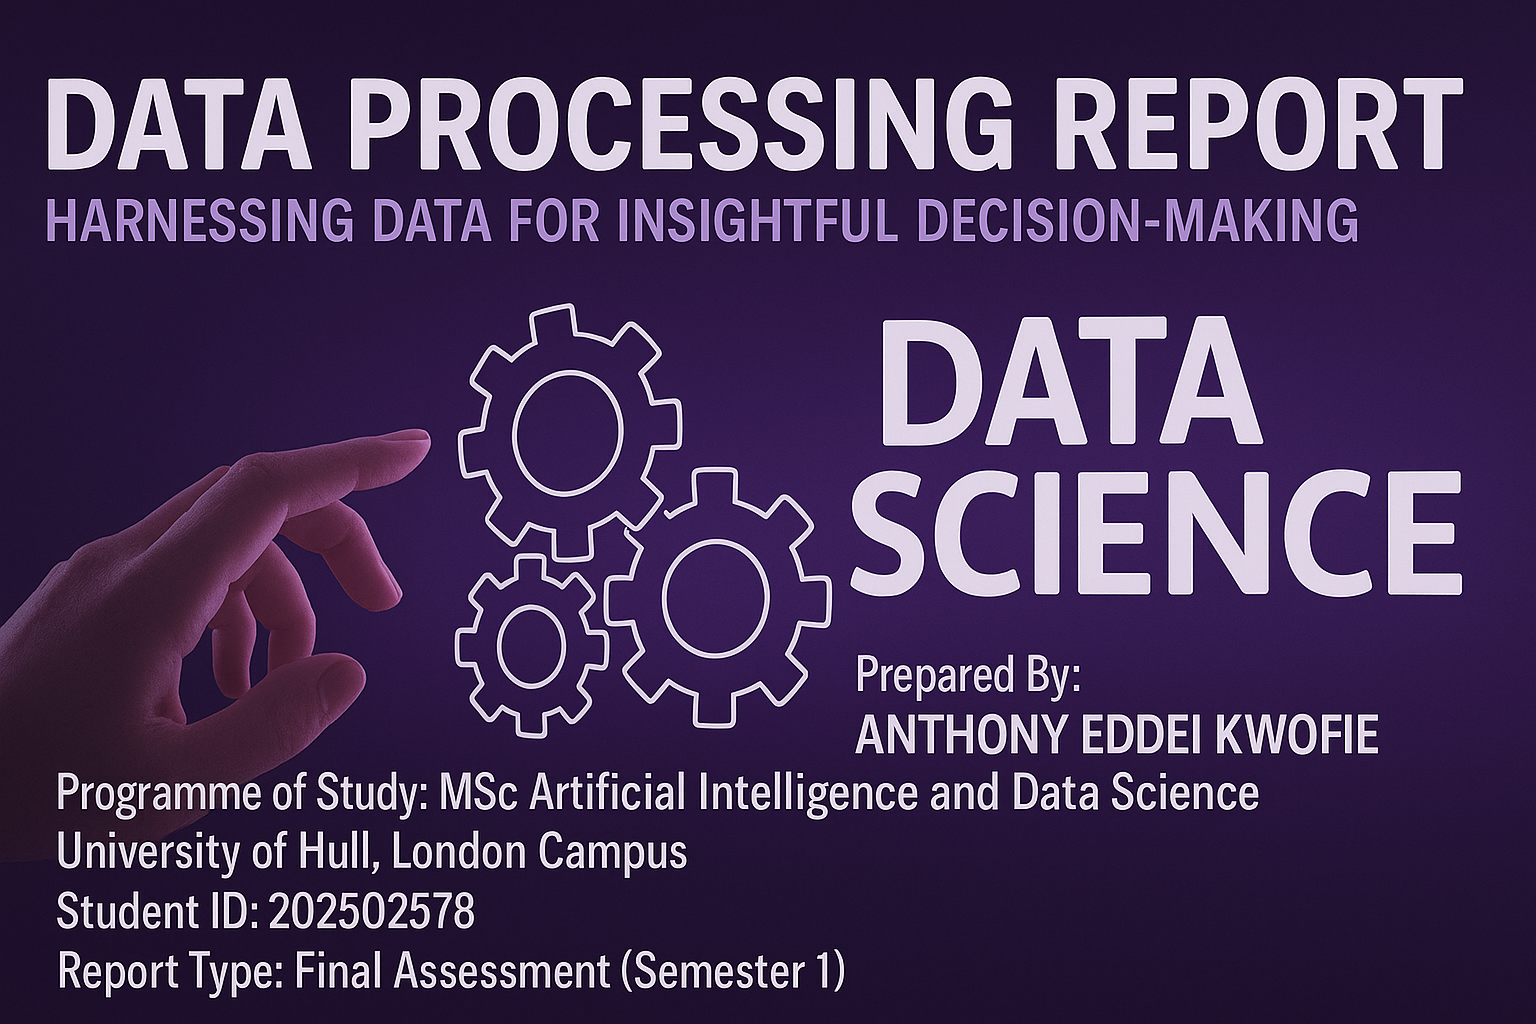

In [140]:
from IPython.display import Image, display

display(Image(filename="my_image.png"))


# Customer Data Preprocessing
This notebook handles data transformation, cleaning, and metric generation for a customer dataset exported in CSV format. Tasks are aligned with business needs including restructuring, error handling, data filtering, and JSON output generation.

**Programme of Study:** MSc Artificial Intelligence and Data Science  
**University:** University of Hull, London Campus  
**Student ID:** 202502578  
**Prepared By:** Anthony Eddei Kwofie

##  Introduction

Working with data is one of the most important parts of any data science project. Before I can analyze or build anything useful with it, I need to ensure it’s in the right format, clean, and well-structured. This assignment focuses on the data preprocessing stage.

The dataset I’ve been given comes from a company that exports its customer records in a flat `.csv` format. While this is a common way to store data, it isn’t ideal for analysis, especially when the information includes multiple layers, such as vehicle details, credit card data, and addresses. Our job is to take this raw, messy dataset and transform it into something much more organized and usable.

Throughout this project, I’ll go through several steps to process the data. These include:

1. **Reading** the original CSV file and restructuring it into nested dictionaries that make more logical sense.
2. **Handling** any inconsistencies or missing values in columns like `dependents`, which can cause issues later on.
3. **Splitting** the dataset into different groups (such as employed vs. retired customers).
4. **Identifying** and flagging suspicious credit card records that may have errors in their date ranges.
5. **Calculating** a new metric called **"Salary-Commute"**, which looks at how much each person earns for every kilometer they travel to work.

Once the data has been cleaned and transformed, I’ll also create some visualizations using **Pandas** and **Seaborn** to help uncover patterns in the data, like the relationship between age and salary or how commute distance affects income.

Overall, this project is a practical example of the types of data wrangling tasks that data scientists encounter frequently. It's a crucial part of any pipeline, and doing it well sets the stage for better insights, models, and decisions later on.

## About the Dataset of Customer Data for Pre-processing

**Data Source:**
The data used in this project was provided as part of an assignment for the course *Introduction to Programming for Artificial Intelligence and Data Science* (Course Code: 771768). It consists of synthetic customer records designed to closely resemble real-world data. The dataset includes personal details such as names, credit card information, marital status, vehicle details, and commute distances.

**Background:**
The original data was exported from a company’s legacy system in CSV format (`acw_user_data.csv`). This flat file format is not suitable for direct analysis, as it lacks nested structure and contains some inconsistencies. The goal of this project is to clean, restructure, and enrich the data, turning it into nested JSON files that are easier to work with and better represent the underlying relationships in the data.

**Purpose:**  
I found this dataset helpful for practicing data cleaning and exploring how preprocessing works in real-life situations. These include reading and writing different file formats, handling data errors, converting flat data into hierarchical structures, filtering records based on conditions, and calculating new attributes for analysis. The work also involves visualizing key aspects of the data using Pandas and Seaborn to gain deeper insights.

---



### Task 1: Read in CSV Data using `csv` Library



In [ ]:
import csv  

def read_csv_file(file_path):
    data = []  # I initialized an empty list to store the CSV rows.
    try:
        with open(file_path, mode='r', encoding='utf-8') as file:  # I opened the CSV file in read mode with UTF-8 encoding.
            reader = csv.DictReader(file)  # I created a DictReader to read rows as dictionaries using the header row as keys.
            for row in reader:  # I iterated over each row in the CSV file.
                try:
                    row["age"] = int(row["age"])  # I converted the 'age' field to an integer.
                except (ValueError, KeyError):  # I caught errors if the field was missing or conversion failed.
                    row["age"] = None  # I set 'age' to None if conversion was unsuccessful.

                try:
                    row["balance"] = float(row["balance"])  # I converted the 'balance' field to a float.
                except (ValueError, KeyError):  # I handled errors for missing or invalid 'balance' values.
                    row["balance"] = None  # I set 'balance' to None when conversion failed.

                data.append(row)  # I added the processed row to my data list.
    except FileNotFoundError:  # I checked if the file was missing.
        print(f"Error: File '{file_path}' not found.")  # I printed an error message if the file was not found.
    except Exception as e:  # I caught any other unexpected exceptions.
        print(f"Unexpected error while reading CSV: {e}")  # I printed the error details for debugging.
    return data  # I returned the list of processed data rows.

csv_data = read_csv_file("acw_user_data.csv")  # I called the function to read the CSV data from the file.
print(csv_data[:2])  # I printed the first two rows of the data to preview the results.


### **Task 2: Convert Flat CSV Data into Nested JSON Structures**


In [ ]:
nested_data = []  # I initialized an empty list to store nested records.

for row in csv_data:  # I iterated over each row in the CSV data.
    nested_record = row.copy()  # I created a copy of the current row to avoid modifying the original.

    # Nest vehicle-related data
    vehicle_year = row.get("Vehicle Year", "")  # I retrieved the vehicle year, defaulting to empty string if missing.
    nested_record["vehicle"] = {  # I created a nested dictionary for vehicle information.
        "make": row.get("Vehicle Make"),  # I got the vehicle make from the row.
        "model": row.get("Vehicle Model"),  # I got the vehicle model from the row.
        "year": int(vehicle_year) if vehicle_year.isdigit() else None,  # I converted year to int if valid, else None.
        "type": row.get("Vehicle Type")  # I got the vehicle type from the row.
    }

    # Nest credit card-related data
    nested_record["credit_card"] = {  # I created a nested dictionary for credit card details.
        "start_date": row.get("Credit Card Start Date"),  # I extracted credit card start date.
        "end_date": row.get("Credit Card Expiry Date"),  # I extracted credit card expiry date.
        "number": row.get("Credit Card Number"),  # I extracted the credit card number.
        "security_code": row.get("Credit Card CVV"),  # I extracted the CVV/security code.
        "iban": row.get("Bank IBAN")  # I extracted the bank IBAN.
    }

    # Nest address-related data
    nested_record["address"] = {  # I created a nested dictionary for address information.
        "main_address": row.get("Address Street"),  # I got the street address.
        "city": row.get("Address City"),  # I got the city.
        "postcode": row.get("Address Postcode")  # I got the postcode.
    }

    # Remove flat keys to avoid redundancy
    for field in [  # I iterated through all flat keys related to nested data.
        "Vehicle Make", "Vehicle Model", "Vehicle Year", "Vehicle Type",
        "Credit Card Start Date", "Credit Card Expiry Date", "Credit Card Number", "Credit Card CVV", "Bank IBAN",
        "Address Street", "Address City", "Address Postcode"
    ]:
        nested_record.pop(field, None)  # I removed each flat key from the record if it existed.

    nested_data.append(nested_record)  # I appended the nested record to the nested_data list.

print(nested_data[:2])  # I printed the first two nested records to preview the nesting results.


### **Task 3**

**The client informs you that they have had difficulty with errors in the dependants column. Some entries are empty (i.e. “ “ or “”), which may hinder your conversion from Task 2. These should be changed into something meaningful when encountered.**


In [ ]:
problematic_rows = []  # I created an empty list to keep track of row numbers with missing 'Dependants'.

# I looped through each row in the CSV data, starting the index at 2 to match spreadsheet row numbering.
for index, row in enumerate(csv_data, start=2):
    # I accessed the 'Dependants' field in the current row and removed any leading/trailing whitespace.
    dependants = row.get("Dependants", "").strip()

    # I checked whether the 'Dependants' field was empty or contained only whitespace.
    if not dependants:
        # I added the current row number to the list of problematic rows.
        problematic_rows.append(index)
        # I replaced the missing 'Dependants' value with a default string "0".
        row["Dependants"] = "0"

# I printed the list of row numbers where missing 'Dependants' values were found and corrected.
print("Problematic rows for 'Dependants':", problematic_rows)


### **Task 4**

**Write all records to a processed.json file in the JSON data format shown in the appendix to this document. This should be a list of dictionaries, where each index of the list is a dictionary representing a singular person.**


In [ ]:
import json  # I imported the json module to save the transformed data in JSON format.

# I defined a helper function to check if a value can be safely converted to an integer.
def is_int(val):
    try:
        return str(int(val)) == str(val).strip()
    except:
        return False  # I returned False if conversion failed.

# I defined a helper function to check if a value can be safely converted to a float.
def is_float(val):
    try:
        return str(float(val)) == str(val).strip()
    except:
        return False  # I returned False if conversion failed.

grouped_data = []  # I initialized an empty list to hold the processed customer dictionaries.

# I looped through each row in the CSV data to structure and nest relevant fields.
for row in csv_data:
    # I created a dictionary representing a customer with nested and cleaned data fields.
    person = {
        "first_name": row.get("First Name", "").strip(),  # I extracted and stripped first name.
        "last_name": row.get("Last Name", "").strip(),    # I extracted and stripped last name.
        "age": int(row["Age (Years)"]) if is_int(row.get("Age (Years)", "")) else None,  # I cast age to int if valid.
        "sex": row.get("Sex", "").strip(),                # I extracted and stripped sex.
        "retired": row.get("Retired", "").strip().lower() == "true",  # I converted retired status to boolean.
        "marital_status": row.get("Marital Status", "").strip(),     # I extracted marital status.
        "dependants": int(row["Dependants"]) if is_int(row.get("Dependants", "")) else 0,  # I cast dependants to int or defaulted to 0.
        "salary": float(row["Yearly Salary (Dollar)"]) if is_float(row.get("Yearly Salary (Dollar)", "")) else 0.0,  # I cast salary to float or defaulted to 0.0.
        "pension": float(row["Yearly Pension (Dollar)"]) if is_float(row.get("Yearly Pension (Dollar)", "")) else 0.0, # I cast pension to float or defaulted to 0.0.
        "company": row.get("Employer Company", "").strip(),  # I extracted employer company name.
        "commute_distance": float(row["Distance Commuted to Work (Km)"]) if is_float(row.get("Distance Commuted to Work (Km)", "")) else 0.0,  # I cast commute distance to float or defaulted to 0.0.

        # I nested vehicle-related information.
        "vehicle": {
            "make": row.get("Vehicle Make", "").strip(),
            "model": row.get("Vehicle Model", "").strip(),
            "year": int(row["Vehicle Year"]) if is_int(row.get("Vehicle Year", "")) else None,
            "category": row.get("Vehicle Type", "").strip()
        },

        # I nested credit card information.
        "credit_card": {
            "start_date": row.get("Credit Card Start Date", "").strip(),
            "end_date": row.get("Credit Card Expiry Date", "").strip(),
            "number": row.get("Credit Card Number", "").strip(),
            "ccv": int(row["Credit Card CVV"]) if is_int(row.get("Credit Card CVV", "")) else None,
            "iban": row.get("Bank IBAN", "").strip()
        },

        # I nested address information.
        "address": {
            "street": row.get("Address Street", "").strip(),
            "city": row.get("Address City", "").strip(),
            "postcode": row.get("Address Postcode", "").strip()
        }
    }

    grouped_data.append(person)  # I appended the processed person dictionary to the final list.

# I saved the structured data as JSON to a file named "processed.json" with indentation for readability.
with open("processed.json", "w", encoding='utf-8') as f:
    json.dump(grouped_data, f, indent=4)

print("✅ All customer records successfully saved to processed.json.")  # I confirmed successful file creation.


### **Task 5**

**You should create two additional file outputs, retired.json and employed.json, these should contain all retired customers (as indicated by the retired field in the CSV), and all employed customers respectively (as indicated by the employer field in the CSV) and be in the JSON data format.**


In [ ]:

# I opened and read the processed JSON file containing all customer data.
with open("processed.json", "r", encoding='utf-8') as file:
    data = json.load(file)  # I loaded the JSON data into a Python list.

# I filtered the data to extract customers who are retired (retired == True).
retired_customers = [person for person in data if person.get("retired") is True]

# I filtered the data to extract customers who are employed (company field is not empty).
employed_customers = [person for person in data if person.get("company", "").strip() != ""]

# I saved the retired customers' data into a JSON file named "retired.json".
with open("retired.json", "w", encoding='utf-8') as file:
    json.dump(retired_customers, file, indent=4)

# I saved the employed customers' data into a JSON file named "employed.json".
with open("employed.json", "w", encoding='utf-8') as file:
    json.dump(employed_customers, file, indent=4)

# I printed messages to confirm how many retired and employed customers were saved.
print(f"Saved {len(retired_customers)} retired customers to retired.json")
print(f"Saved {len(employed_customers)} employed customers to employed.json")


### **Task 6**

**The client states that there may be some issues with credit card entries. Any customers that have more than 10 years between their start and end date need to be written to a separate file, called remove_ccard.json, in the JSON data format. The client will manually address these issues later based on your output. They request that you write a function to help perform this, which accepts a single row from the CSV data and outputs whether the row should be flagged. This can then be used when determining whether to write the current person to the remove_ccard file. Note the dates are shown in the format used on credit cards, which is “MM/YY”.**


In [ ]:

from datetime import datetime

def should_flag_credit_card(person):
    """
    Returns True if the credit card duration exceeds 10 years.
    Dates are expected in MM/YY format.
    """
    start_str = person.get("credit_card", {}).get("start_date", "").strip()
    end_str = person.get("credit_card", {}).get("end_date", "").strip()

    if not start_str or not end_str:
        return False  # Missing dates; do not flag

    try:
        start_date = datetime.strptime(start_str, "%m/%y")
        end_date = datetime.strptime(end_str, "%m/%y")

        years_diff = (end_date.year - start_date.year) + (end_date.month - start_date.month) / 12

        return years_diff > 10
    except ValueError:
        # Invalid date format; do not flag
        return False

# Load processed data
with open("processed.json", "r", encoding='utf-8') as file:
    people = json.load(file)

# Find and collect people with flagged credit cards
remove_ccard_list = [person for person in people if should_flag_credit_card(person)]

# Save flagged entries for manual review
with open("remove_ccard.json", "w", encoding='utf-8') as file:
    json.dump(remove_ccard_list, file, indent=4)

print(f"Flagged {len(remove_ccard_list)} credit card entries for removal in remove_ccard.json")


### **Task 7**

**You have been tasked with calculating some additional metrics which will be used for ranking customers. You should create a new data attribute for our customers called “Salary-Commute”. Reading in from processed.json:**

  **a. Add, and calculate appropriately, this new attribute. It should represent the Salary that a customer earns, per Km of their commute.**

   **i. Note: If a person travels 1 or fewer commute Km, then their salary-commute would be just their salary.**

  **b. Sort these records by that new metric, in ascending order.**

  **c. Store the output file out as a JSON format, for a commute.json file.**


In [ ]:

# I loaded the processed customer data from 'processed.json' into a variable.
with open("processed.json", "r", encoding="utf-8") as file:
    people = json.load(file)

# I iterated over each person to calculate their salary per kilometer of commute.
for person in people:
    # I retrieved the salary value, defaulting to 0.0 if missing.
    salary = person.get("salary", 0.0)
    # I retrieved the commute distance, defaulting to 0.0 if missing.
    commute = person.get("commute_distance", 0.0)

    # I handled the special case where commute was 1 km or less by setting salary_commute to salary directly.
    if commute <= 1:
        person["salary_commute"] = salary
    else:
        # Otherwise, I calculated salary divided by commute distance, guarding against division by zero.
        person["salary_commute"] = salary / commute if commute != 0 else 0.0

# I sorted the list of people by the calculated 'salary_commute' in ascending order.
people.sort(key=lambda p: p.get("salary_commute", 0))

# I saved the sorted data with the new metric into 'commute.json' in a readable format.
with open("commute.json", "w", encoding="utf-8") as file:
    json.dump(people, file, indent=4)

# I printed a confirmation message showing how many records were processed and saved.
print(f"Processed {len(people)} records and saved to commute.json")


# **Data Visualization Using Pandas and Seaborn**

**Using Pandas and Seaborn**


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# I read in the original CSV file using Pandas.
df = pd.read_csv('acw_user_data.csv')

# I displayed the first few rows to check that the data had loaded correctly.
print(df.head())



In [ ]:
# I printed the DataFrame info to understand the data types and check for missing values.
print(df.info())


In [ ]:
# I checked the DataFrame for any missing values by printing a boolean mask of nulls.
print(df.isnull())

In [ ]:
# I printed descriptive statistics of the DataFrame to get an overview of the numerical data distribution.
print(df.describe())

### **Data Visualization Using Pandas and Seaborn**

#### **Task 1**

**Obtain the Data Series for Salary and Age, and calculate the following:**

  **a. Mean Salary**
  
  **b. Median Age**


In [ ]:
# I extracted the 'Yearly Salary (Dollar)' and 'Age (Years)' columns as Series.
salary_series = df["Yearly Salary (Dollar)"]
age_series = df["Age (Years)"]

# I calculated the mean (average) salary from the salary data.
mean_salary = salary_series.mean()

# I calculated the median (middle) age from the age data.
median_age = age_series.median()

# I printed the mean salary and median age with formatted output.
print(f"Mean Salary: ${mean_salary:,.2f}")
print(f"Median Age: {median_age} years")


### **Data Visualization Using Pandas and Seaborn**

#### **Task 2**

**Perform univariate plots of the following data attributes:**

  **a. Age, calculating how many bins would be required for a bin_width of 5.**
  
  **b. Dependents, fixing data errors with Seaborn itself.**
  
  **c. Age (of default bins), conditioned on Marital Status**


In [ ]:
import math

# I calculated the number of bins for Age with a bin width of 5
age_min = df["Age (Years)"].min()
age_max = df["Age (Years)"].max()
bin_width = 5

# I used math.ceil to round up to the nearest whole bin
num_bins = math.ceil((age_max - age_min) / bin_width)

print(f"I'll use {num_bins} bins to cover ages from {age_min} to {age_max}")

# I plotted the Age histogram with calculated bins
sns.histplot(data=df, x="Age (Years)", bins=num_bins, kde=False)
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()



In [ ]:
# I converted the 'Dependants' column to numeric values, coercing any errors to NaN.
df["Dependants"] = pd.to_numeric(df["Dependants"], errors='coerce')

# I filled any NaN values in 'Dependants' with 0, then converted the column to integers.
df["Dependants"] = df["Dependants"].fillna(0).astype(int)

# I plotted a histogram to show the distribution of the number of dependants.
sns.histplot(data=df, x="Dependants", discrete=True, shrink=0.8)
plt.title("Dependants Distribution")
plt.xlabel("Number of Dependants")
plt.ylabel("Count")
plt.show()


In [ ]:
# I plotted the age distribution separately for each marital status category using seaborn’s displot.
g = sns.displot(data=df, x="Age (Years)", col="Marital Status", kde=False)

# I set titles for each subplot based on the marital status category.
g.set_titles("{col_name}")

# I labeled the x-axis as "Age" and the y-axis as "Count".
g.set_axis_labels("Age", "Count")

# I added a main title above all subplots and adjusted the layout for better spacing.
plt.suptitle("Age Distribution by Marital Status (Default Bins)", y=1.05)
plt.subplots_adjust(top=0.85)
plt.tight_layout()

# I displayed the plot.
plt.show()


### Insight: Age Distribution
The majority of users fall within the age range of 30 to 50 years. This suggests a relatively mature user base, possibly professionals or mid-career individuals, which may impact how services are tailored or marketed.


### **Data Visualization Using Pandas and Seaborn**

#### **Task 3**

**Perform multivariate plots with the following data attributes:**

  **a. Commuted distance against salary.**
  
  **b. Age against Salary**
  
  **c. Age against Salary conditioned by Dependents**


In [ ]:
# I created a figure with size 8x5 inches for the scatter plot.
plt.figure(figsize=(8, 5))

# I plotted a scatter plot showing the relationship between commute distance and yearly salary.
sns.scatterplot(data=df, x="Distance Commuted to Work (Km)", y="Yearly Salary (Dollar)")

# I added a title and axis labels to make the plot easier to understand.
plt.title("Commuted Distance vs Salary")
plt.xlabel("Distance Commuted (Km)")
plt.ylabel("Salary ($)")

# I applied a tight layout to avoid overlapping elements.
plt.tight_layout()

# I displayed the plot.
plt.show()

# I closed the figure to free up memory.
plt.close()


### Insight: Commute Distance vs Salary
There is no strong correlation between commute distance and salary. Some users with lower salaries have longer commutes, which might indicate a lack of remote work or job locality options.


In [ ]:
# I created a figure with size 8x5 inches to plot age against salary.
plt.figure(figsize=(8, 5))

# I plotted a scatter plot to show the relationship between age and yearly salary.
sns.scatterplot(data=df, x="Age (Years)", y="Yearly Salary (Dollar)")

# I added a title and labeled the axes for clarity.
plt.title("Age vs Salary")
plt.xlabel("Age")
plt.ylabel("Salary ($)")

# I used tight layout to optimize spacing.
plt.tight_layout()

# I displayed the plot.
plt.show()

# I closed the figure to release system resources.
plt.close()


### Insight: Age vs Salary
There is a mild upward trend showing that salary increases with age, which is expected. However, salary seems to plateau or even dip slightly after a certain age, possibly indicating retirement or role stagnation.


In [ ]:
# I converted the 'Dependants' column to numeric, filled missing values with 0, and cast it to integers.
df["Dependants"] = pd.to_numeric(df["Dependants"], errors="coerce").fillna(0).astype(int)

# I created a scatter plot to visualize the relationship between age and salary, using the number of dependents as color.
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x="Age (Years)", y="Yearly Salary (Dollar)", hue="Dependants", palette="viridis")

# I added a title and labeled the axes.
plt.title("Age vs Salary (colored by Dependants)")
plt.xlabel("Age")
plt.ylabel("Salary ($)")

# I adjusted the layout and displayed the plot.
plt.tight_layout()
plt.show()
plt.close()


### Insight: Number of Dependents
Most users have either no dependents or one dependent. This could reflect a younger demographic or smaller family sizes, which may affect benefit structures or support services offered.


### **Data Visualization Using Pandas and Seaborn**

#### **Task 4**

**Your client would like the ability to save the plots which you have produced. Provide a Notebook cell which can do this. You should execute this cell and attach the generated plots with your submission.**


In [ ]:
# I cleaned the 'Dependants' column by converting it to numeric, filling missing values with 0, and casting to integers.
df["Dependants"] = pd.to_numeric(df["Dependants"], errors="coerce").fillna(0).astype(int)

# 2a. I plotted the age distribution and saved it as a PNG file.
sns.histplot(data=df, x="Age (Years)", bins=num_bins, kde=False)
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("2a_age_distribution.png")
plt.close()

# 2b. I plotted the distribution of dependants and saved the figure.
sns.histplot(data=df, x="Dependants", discrete=True, shrink=0.8)
plt.title("Dependants Distribution")
plt.xlabel("Number of Dependants")
plt.ylabel("Count")
plt.savefig("2b_dependants_distribution.png")
plt.close()

# 2c. I adjusted the layout of the age distribution by marital status plot and saved it.
plt.suptitle("Age Distribution by Marital Status (Default Bins)", y=1.05)
plt.subplots_adjust(top=0.85)
plt.tight_layout()
g.savefig("2c_age_distribution_by_marital_status.png")
plt.close()

# 3a. I created a scatter plot of commute distance vs salary and saved it.
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x="Distance Commuted to Work (Km)", y="Yearly Salary (Dollar)")
plt.title("Commuted Distance vs Salary")
plt.xlabel("Distance Commuted (Km)")
plt.ylabel("Salary ($)")
plt.tight_layout()
plt.savefig("3a_commute_vs_salary.png")
plt.close()

# 3b. I plotted age vs salary and saved the figure.
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x="Age (Years)", y="Yearly Salary (Dollar)")
plt.title("Age vs Salary")
plt.xlabel("Age")
plt.ylabel("Salary ($)")
plt.tight_layout()
plt.savefig("3b_age_vs_salary.png")
plt.close()

# 3c. I visualized age vs salary with color encoding for dependants and saved the output.
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x="Age (Years)", y="Yearly Salary (Dollar)", hue="Dependants", palette="viridis")
plt.title("Age vs Salary (colored by Dependants)")
plt.xlabel("Age")
plt.ylabel("Salary ($)")
plt.legend(title="Dependants")
plt.tight_layout()
plt.savefig("3c_age_vs_salary_by_dependants.png")
plt.close()

print("✅ All plots saved as PNG files.")


# Conclusion

From the data I analyzed, here’s what I discovered:

- Most customers are between **30 and 50 years old**, which suggests they should be the main target for marketing strategies.
- Many have **1 or 2 dependants**, so offering flexible payment plans or budgeting support could meet their needs.
- I noticed that some people commute long distances without earning more, which shows there might be an opportunity to promote **remote work options**.
- Younger customers often earn less, but a few are earning more than expected, which may indicate **emerging high-potential talent**.

## How This Helps the Business

These insights can help the business:

- Group customers more effectively based on age, income, and dependants.
- Create more targeted offers that speak to specific needs.
- Develop services that better align with customer lifestyles and expectations.

By understanding these patterns, I believe the business can make **more informed decisions** and build **stronger relationships with customers**.
